In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import deluca.core
import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt
from deluca.lung import ROOT
from deluca.lung.environments._stitched_sim import StitchedSim
from deluca.lung.experimental.controllers import Deep, deep_train
from deluca.lung.utils.scripts.run_controller import run_controller_scan
from deluca.lung.utils.data.analyzer import Analyzer
from deluca.lung.utils.core import BreathWaveform
from deluca.lung.controllers import PID
from deluca.lung.controllers import BangBang

In [3]:
def plot_controller_on_breathwaveform(controller, sim, abort=70, T=29, use_tqdm=False, **kwargs):
    waveform = BreathWaveform.create()
    run_data = run_controller_scan(
                controller, R=None, C=None, T=T, abort=abort, use_tqdm=use_tqdm, env=sim, waveform=waveform, **kwargs
            )
    analyzer = Analyzer(run_data)
    analyzer = Analyzer(run_data)
    preds = analyzer.pressure.copy()
    truth = analyzer.target.copy()
    loss = jnp.abs(preds - truth).mean()
    analyzer.plot(legend=True)
    print('loss:' + str(loss))
    return loss
loss_per_controller = {}

# Load Simulator Trained Params

In [4]:
sim = deluca.load(f"{ROOT}/pkls/sim.pkl")

# Load and Run Deep Controller

In [5]:
deep_controller = deluca.load(f"{ROOT}/pkls/deep_controller.pkl")

loss:5.1513033


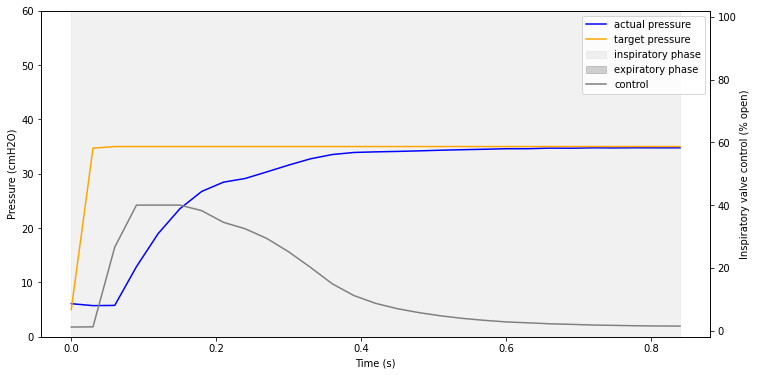

In [6]:
loss_per_controller['deep'] = plot_controller_on_breathwaveform(deep_controller, sim)

# Run PID Controller

loss:6.7851048


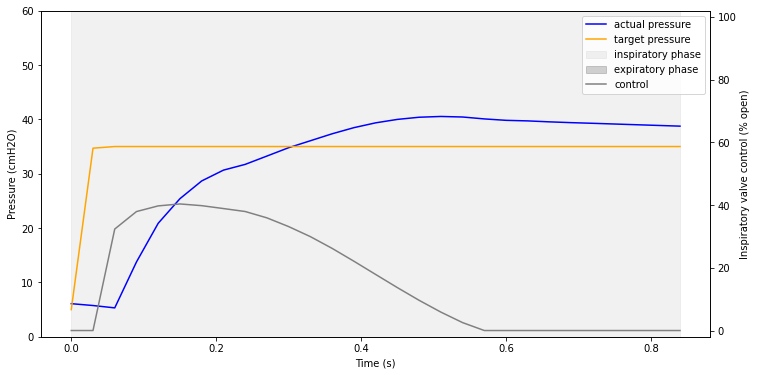

In [7]:
waveform = BreathWaveform.create()
params = {'K' : {'kernel' : jnp.array([[0.], [10.], [10.]])}}
pid = PID.create(waveform=waveform, params=params)
loss_per_controller['PID'] = plot_controller_on_breathwaveform(pid, sim)

# Run BangBang Controller

loss:8.988764


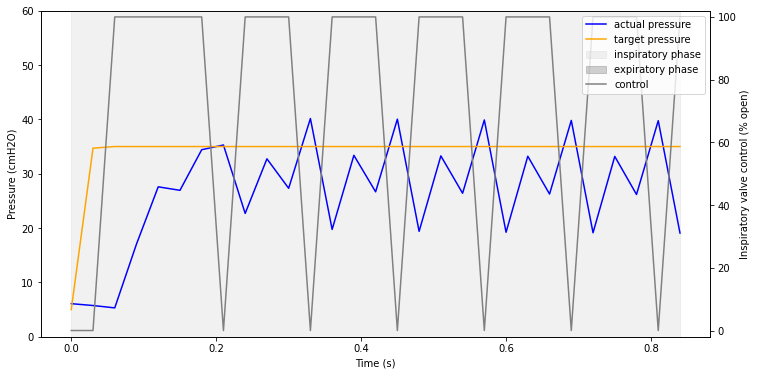

In [8]:
waveform = BreathWaveform.create()
bangbang = BangBang.create(waveform=waveform)
loss_per_controller['BangBang'] = plot_controller_on_breathwaveform(bangbang, sim)

# Compare Controller Losses

<BarContainer object of 3 artists>

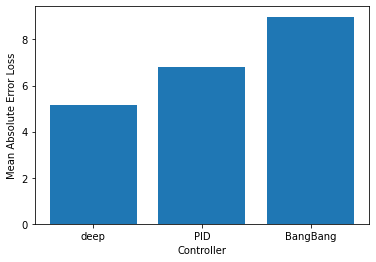

In [9]:
keys = loss_per_controller.keys()
values = loss_per_controller.values()
axes = matplotlib.pyplot.axes()
axes.set_xlabel("Controller")
axes.set_ylabel("Mean Absolute Error Loss")
plt.bar(keys, values)